**Configure Devices**

In [1]:
import sys
import tensorflow as tf
sys.path.append('./rcwa_tf/src/')
import tf_utils

In [2]:
# Limit GPU memory growth.
tf_utils.config_gpu_memory_usage()

# Choose the device to run on.
use_gpu = True
tfDevice = '/job:localhost/replica:0/task:0/device:GPU:1' if use_gpu else '/CPU:0'
print('Executing on device ' + tfDevice + ' ...')

# Measure GPU memory usage.
gpu_memory_init = tf_utils.gpu_memory_info()

 
2 Physical GPUs
Executing on device /CPU:0 ...


**Dependencies**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import solver
import solver_metasurface
import time

**Loss Function Definition**

In [4]:
def focal_spot(h, params):

    # Generate permittivity and permeability distributions.
    ER_t, UR_t = solver_metasurface.generate_layered_metasurface(h, params)

    # Simulate the system.
    outputs = solver.simulate(ER_t, UR_t, params)

    # First loss term: maximize sum of electric field magnitude within some radius of the desired focal point.
    r = params['focal_spot_radius']
    field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
    focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    index = (params['pixelsX'] * params['upsample']) // 2
    l1 = tf.math.reduce_sum(tf.abs(focal_plane[0, index-r:index+r, index-r:index+r]))

    # Second loss term: minimize sum of electric field magnitude elsewhere.
    l2 = tf.math.reduce_sum(tf.abs(focal_plane[0, :, :])) - l1

    # Final loss: (negative) field intensity at focal point + field intensity elsewhere.
    return -params['w_l1']*l1 + params['w_l2']*l2

**Initialize User-Configurable Parameters**

In [5]:
with tf.device(tfDevice):
    
    # Initialize dict of user-configurable parameters.
    user_params = {}
    
    # Flage to enable hyperparameter grid search.
    user_params['enable_hyperparameter_gridsearch'] = False
    
    # Tunable parameters.
    user_params['N'] = 10
    user_params['sigmoid_update'] = 40.0
    user_params['learning_rate'] = 8E-1
    
    # Values to use in hyperparameter grid search.
    # Stored as a dict. Each dict key is the key in user_params corresponding to a tunable
    # hyperparameter, i.e. 'N' and its value is a list of values to try for that hyperparameter.
    param_grid = {'N': [10, 20],
                  'sigmoid_update': [20.0, 40.0],
                  'learning_rate': [8E-1] }
    user_params['param_grid'] = param_grid
    
    
    # Source parameters.
    user_params['wavelengths'] = [120000.0]
    user_params['thetas'] = [0.0]
    user_params['phis'] = [0.0]
    user_params['pte'] = [1.0]
    user_params['ptm'] = [0.0]
    user_params['batchSize'] = len(user_params['wavelengths'])
    
    # Device parmeters.
    user_params['pixelsX'] = 19
    user_params['pixelsY'] = user_params['pixelsX']
    user_params['erd'] = 12.04
    user_params['ers'] = user_params['erd']
    user_params['eps_min'] = 1.0
    user_params['eps_max'] = user_params['erd']
    user_params['Nlay'] = 6
    user_params['L'] = [50000.0] * user_params['Nlay']
    user_params['Lx'] = 20000.0
    #user_params['Lx'] = 5000000. / user_params['pixelsX']
    user_params['Ly'] = user_params['Lx']
    user_params['f'] = 0.0 # Focal distance (nm)
    
    # Solver parameters.
    user_params['PQ'] = [5,5]
    user_params['Nx'] = 16
    user_params['Ny'] = user_params['Nx']
    user_params['upsample'] = 11
    
    # Problem parameters.
    user_params['w_l1'] = 1.0
    user_params['w_l2'] = 0.0
    user_params['sigmoid_coeff'] = 1.0
    user_params['focal_spot_radius'] = 10
    user_params['random_init'] = False
    user_params['initial_height'] = 0
    user_params['debug'] = False
    user_params['print'] = True
    user_params['enable_timing'] = True
    
    # Loss function.
    user_params['loss_function'] = focal_spot
    
    # TensorFlow parameters.
    user_params['enable_graphmode'] = False

**Run Tests**

In [6]:
with tf.device(tfDevice):
    
    if user_params['enable_timing']:
        start_time = time.time()
            
    if user_params['enable_hyperparameter_gridsearch']:
        
        # Perform the hyperparameter grid search.
        results = solver_metasurface.hyperparameter_gridsearch(user_params)
        
        # Get list of evaluation scores.
        scores = [r['eval_score'] for r in results]

        # Select hyperparameters corresponding to best evaluation score.
        r = results[np.argmax(scores)]
        h = r['h']
        loss = r['loss']
        focal_plane = r['focal_plane']
        eval_score = r['eval_score']
        params = r['params']

        print('Best hyperparameters: ' + str(r['hyperparameters']))
        print('With evaluation score: ' + str(eval_score))
    
    else:
        
        # Optimize.
        h, loss, params = solver_metasurface.optimize_device(user_params)
        
        # Get full device representation of resulting metasurface.
        ER_t, UR_t = solver_metasurface.generate_layered_metasurface(h, params)
        
        # Simulate scattering from the optimized device.
        outputs = solver.simulate(ER_t, UR_t, params)
        field = outputs['ty'][:, :, :, np.prod(params['PQ']) // 2, 0]
        focal_plane = solver.propagate(params['input'] * field, params['propagator'], params['upsample'])
    
    if user_params['enable_timing']:
        print('Completed tests in ' + str(time.time() - start_time) + ' s.')

Optimizing... Iteration 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, Done.
Completed tests in 198.11608576774597 s.


**Display Learning Curve**

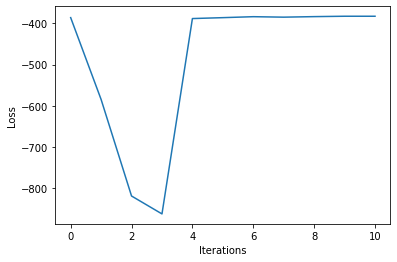

In [7]:
with tf.device(tfDevice):
    
    plt.plot(loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

**Display Resulting Intensity on the Focal Plane**

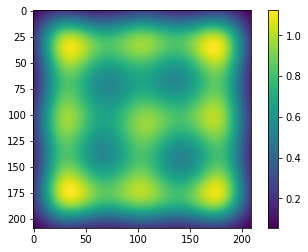

In [8]:
with tf.device(tfDevice):
    
    plt.imshow(tf.abs(focal_plane[0, :, :]) ** 2)
    plt.colorbar()

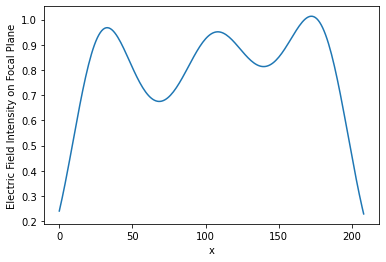

In [9]:
with tf.device(tfDevice):
    
    index = (params['pixelsX'] * params['upsample']) // 2
    plt.plot(tf.abs(focal_plane[0, index, :]) ** 2)
    plt.xlabel('x')
    plt.ylabel('Electric Field Intensity on Focal Plane')
    plt.show()

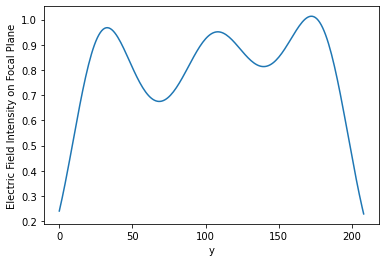

In [10]:
with tf.device(tfDevice):
    
    index = (params['pixelsX'] * params['upsample']) // 2
    plt.plot(tf.abs(focal_plane[0, :, index]) ** 2)
    plt.xlabel('y')
    plt.ylabel('Electric Field Intensity on Focal Plane')
    plt.show()

**Display Metasurface**

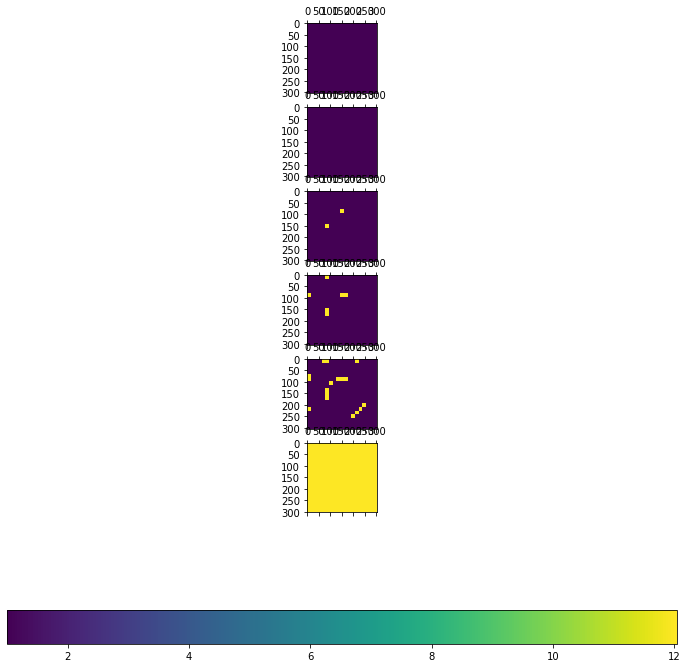

tf.Tensor(
[[0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 1. 3. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [11]:
with tf.device(tfDevice):
    
    ER_t, UR_t = solver_metasurface.generate_layered_metasurface(h, params)
    solver_metasurface.display_layered_metasurface(ER_t, params)
    print(h)

**Check GPU Memory Utilization**

In [12]:
gpu_memory_final = tf_utils.gpu_memory_info()
gpu_memory_used = [gpu_memory_final[1][0] - gpu_memory_init[1][0], gpu_memory_final[1][1] - gpu_memory_init[1][1]]
print('Memory used on each GPU(MiB): ' + str(gpu_memory_used))

Memory used on each GPU(MiB): [305, 417]
